#Classification, Probabilities, ROC curves, and Cost

In [21]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image
from six.moves import xrange

In [47]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    #print ("BEST", gs.best_params_, gs.best_score_, gs.grid_scores_)
    print ("BEST", gs.best_params_, gs.best_score_, gs.cv_results_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    #if mask !=None:
    if (mask !=None).all(): 
        print ("using mask")
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print ("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print ("############# based on standard predict ################")
    print ("Accuracy on training data: %0.2f" % (training_accuracy))
    print ("Accuracy on test data:     %0.2f" % (test_accuracy))
    print (confusion_matrix(ytest, clf.predict(Xtest)))
    print ("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [23]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [54]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    #plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    
    return ax 

##Setting up the data

(I encountered this dataset in Conway, Drew, and John White. Machine learning for hackers. " O'Reilly Media, Inc.", 2012.)

In [25]:
#dfhw=pd.read_csv("https://dl.dropboxusercontent.com/u/75194/stats/data/01_heights_weights_genders.csv")
dfhw=pd.read_csv("01_heights_weights_genders.csv")
print (dfhw.shape)
dfhw.head()

(10000, 3)


,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


We sample 500 points from 10,000, since we actually want to see trends clearly on the plots

In [26]:
df=dfhw.sample(500, replace=False)
np.sum(df.Gender=="Male")

244

We split the data into training and test sets...

In [27]:
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask[:10]

array([ True, False,  True,  True,  True, False,  True,  True,  True,
        True])

In [44]:
(mask !=None).all() 

True

##Logistic regression

Notice that its L2 regularized....

using mask
BEST {'C': 0.1} 0.9433333333333331 {'mean_fit_time': array([0.00868282, 0.01442676, 0.00748067, 0.00817208, 0.01911335,
       0.00827384, 0.00844421, 0.00939274]), 'std_fit_time': array([0.00081174, 0.00547403, 0.0016089 , 0.00050963, 0.01110202,
       0.00033648, 0.00083732, 0.00127944]), 'mean_score_time': array([0.00038018, 0.00042038, 0.00032873, 0.00032883, 0.00048475,
       0.00034184, 0.00040612, 0.00039954]), 'std_score_time': array([8.70199203e-05, 1.06693888e-04, 1.00593429e-05, 3.94480093e-06,
       1.31698366e-04, 3.12455348e-05, 1.64950207e-04, 1.55766169e-04]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}, {'C': 10000}], 'split0_test_score': array([0.93333333, 0.93333333, 0.96666667, 0.95      , 0.95      ,
    

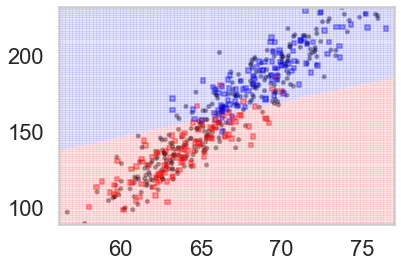

In [48]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In `sklearn`, `clf.predict(test_data)` makes predictions on the assumption that a 0.5 probability threshold is the appropriate thing to do.

In [49]:
clflog.predict(Xtest)

array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0])

The probabilities output by the classifier can be accessed as below. The second column (`[:,1]` in numpy parlance, google numpy indexing to understand the syntax) gives the probability that the sample is a 1 (or +ive), here Male.

In [50]:
clflog.predict_proba(Xtest)

array([[3.89236564e-03, 9.96107634e-01],
       [9.42931297e-05, 9.99905707e-01],
       [3.00675184e-03, 9.96993248e-01],
       [9.99635292e-01, 3.64707585e-04],
       [2.83141963e-06, 9.99997169e-01],
       [8.00701629e-01, 1.99298371e-01],
       [4.86933740e-01, 5.13066260e-01],
       [4.02992584e-01, 5.97007416e-01],
       [9.85913591e-01, 1.40864090e-02],
       [7.76026156e-01, 2.23973844e-01],
       [9.93171769e-01, 6.82823109e-03],
       [2.11839108e-04, 9.99788161e-01],
       [9.97716481e-01, 2.28351862e-03],
       [9.97556053e-01, 2.44394747e-03],
       [9.54772598e-01, 4.52274023e-02],
       [9.64515663e-05, 9.99903548e-01],
       [8.66853187e-03, 9.91331468e-01],
       [9.26466787e-01, 7.35332128e-02],
       [9.99981618e-01, 1.83817560e-05],
       [3.47487891e-04, 9.99652512e-01],
       [1.77964505e-02, 9.82203550e-01],
       [9.99942648e-01, 5.73517953e-05],
       [1.67873507e-02, 9.83212649e-01],
       [8.75266189e-01, 1.24733811e-01],
       [2.626001

In [51]:
clflog.predict_proba(Xtest)[:,1]

array([9.96107634e-01, 9.99905707e-01, 9.96993248e-01, 3.64707585e-04,
       9.99997169e-01, 1.99298371e-01, 5.13066260e-01, 5.97007416e-01,
       1.40864090e-02, 2.23973844e-01, 6.82823109e-03, 9.99788161e-01,
       2.28351862e-03, 2.44394747e-03, 4.52274023e-02, 9.99903548e-01,
       9.91331468e-01, 7.35332128e-02, 1.83817560e-05, 9.99652512e-01,
       9.82203550e-01, 5.73517953e-05, 9.83212649e-01, 1.24733811e-01,
       7.37399888e-01, 4.13606728e-03, 7.41273252e-03, 9.95281268e-01,
       9.99950505e-01, 8.99592193e-03, 1.65610909e-01, 9.96700860e-01,
       4.15778910e-04, 3.20258100e-02, 1.00180146e-04, 6.84194784e-04,
       4.84956486e-01, 7.24396818e-01, 8.06863167e-01, 7.97416828e-01,
       1.20974487e-03, 9.47614391e-04, 4.76549168e-01, 4.12053004e-01,
       1.74853612e-02, 1.25692278e-03, 9.89442996e-01, 9.05152656e-01,
       3.86467503e-03, 2.26741695e-05, 9.86755605e-01, 9.84525548e-01,
       4.23828483e-01, 7.58688447e-03, 3.15605645e-04, 8.43611322e-01,
      

Lots of sure females and sure males when you plot the probability of being a male:

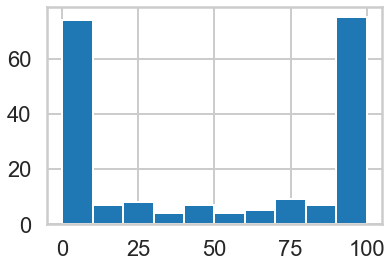

In [52]:
plt.hist(clflog.predict_proba(Xtest)[:,1]*100);

We can plot the probability contours: these are rather tight!

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'axes'
  
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'axes'
  if __name__ == '__main__':


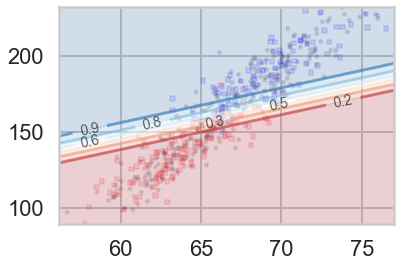

In [55]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog);

The score function of the estimator is used to evaluate a parameter setting. These are the sklearn.metrics.accuracy_score for classification and sklearn.metrics.r2_score for regression. For some applications, other scoring functions are better suited (for example in unbalanced classification, the accuracy score is often uninformative). We can pass other scorers to `GridSearchCV`.

In [56]:
clflog.score(Xtest, ytest)

0.92

##SVM

Lets do a linear SVM instead. As mentioned in the last lab, SVM is a discriminant classifier..it is not probabilistic.

using mask
BEST {'C': 1} 0.9366666666666665 {'mean_fit_time': array([0.00377231, 0.00105634, 0.00201383, 0.00592337, 0.02274756,
       0.13562064, 0.38113165]), 'std_fit_time': array([0.00592517, 0.00050811, 0.00039987, 0.0010399 , 0.00737118,
       0.04924094, 0.2032291 ]), 'mean_score_time': array([0.00109096, 0.00047073, 0.00068235, 0.00114431, 0.00048099,
       0.0004703 , 0.00051818]), 'std_score_time': array([1.42893582e-03, 1.65986981e-04, 1.38333821e-04, 5.80396477e-04,
       3.46738329e-05, 4.25633192e-05, 6.96328553e-05]), 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}], 'split0_test_score': array([0.93333333, 0.93333333, 0.95      , 0.95      , 0.95      ,
       0.96666667, 0.96666667]), 'split1_test_score': array([0.93333333, 0.93333333, 0

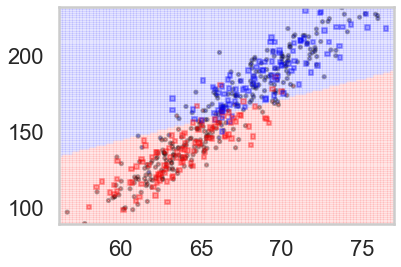

In [57]:
from sklearn.svm import SVC
clfsvm = SVC(kernel="linear")
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
clfsvm, Xtrain, ytrain, Xtest, ytest=do_classify(clfsvm, parameters, df, ['Height','Weight'],'Gender', "Male", mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);

This there is no `predict_proba`. Instead, we get to use `decision_function`, which give us whatever the said classifier is using to discriminate...

In [58]:
clfsvm.decision_function(Xtest)

array([ 4.09846301e+00,  6.91979115e+00,  4.67865498e+00, -6.13595019e+00,
        9.80661788e+00, -1.10864043e+00,  8.86416740e-02,  3.88614020e-01,
       -3.09612148e+00, -9.36138762e-01, -3.86769824e+00,  6.37432028e+00,
       -4.66327923e+00, -4.71771817e+00, -2.50047685e+00,  6.78553014e+00,
        3.60707084e+00, -2.27586733e+00, -8.52695647e+00,  5.92780272e+00,
        2.92781442e+00, -7.48072140e+00,  2.96817081e+00, -1.26959146e+00,
        5.91270908e-01, -4.35213611e+00, -3.64451761e+00,  4.00267591e+00,
        7.66620724e+00, -3.73153340e+00, -1.29596476e+00,  4.20597971e+00,
       -5.81355780e+00, -2.67614144e+00, -6.83033140e+00, -5.65810242e+00,
        3.23921175e-02,  7.11823494e-01,  1.06527474e+00,  9.56778474e-01,
       -4.94689102e+00, -5.22055344e+00, -1.28283684e-01, -3.72816675e-01,
       -3.11701005e+00, -5.11029774e+00,  3.59216757e+00,  1.86739530e+00,
       -4.31495685e+00, -8.16817057e+00,  2.98539145e+00,  3.30529140e+00,
       -2.90901801e-01, -

We can plt a histogram. In terms of distance from the separator, we can see that most samples on either side are a middling distance away. This is different from the probability diagram

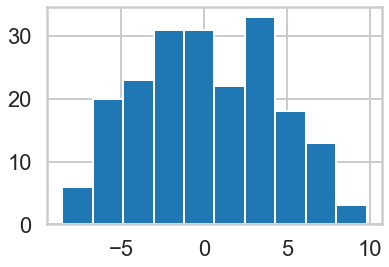

In [59]:
plt.hist(clfsvm.decision_function(Xtest));

Its clearer when u plot the `decision_function` on the plane...

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'axes'
  
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'axes'
  if __name__ == '__main__':


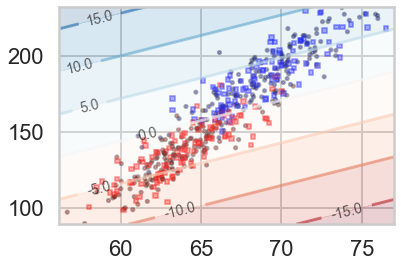

In [60]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, mesh=False);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clfsvm, prob=False);

The decision function can be used to plot the margins of the SVM.

In [67]:
#From Jake Vanderplas's ESAC notebook
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            #P[i, j] = clf.decision_function([xi, yj])
            P[i, j] = clf.decision_function([xi, yj].reshape(-1, 1))
    return ax.contour(X, Y, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

and we can also access the support vectors....

AttributeError: 'list' object has no attribute 'reshape'

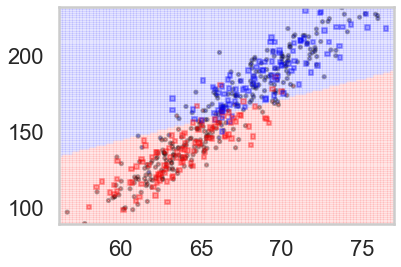

In [68]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clfsvm);
plot_svc_decision_function(clfsvm, ax)
ax.scatter(clfsvm.support_vectors_[:, 0], clfsvm.support_vectors_[:, 1],s=200, facecolors='none')
plt.ylim([125,225])

##The confusion Matrix

We have written two classifiers. A classifier will get some samples right, and some wrong. Generally we see which ones it gets right and which ones it gets wrong on the test set. There,

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix from these which lookslike this:

![hwimages](./images/confusionmatrix.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`

In [69]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[94, 10],
       [ 6, 90]])

Given these definitions, we typically calculate a few metrics for our classifier. First, the **True Positive Rate**:

$$TPR = Recall = \frac{TP}{OP} = \frac{TP}{TP+FN},$$

also called the Hit Rate: the fraction of observed positives (1s) the classifier gets right, or how many true positives were recalled. Maximizing the recall towards 1 means keeping down the false negative rate. In a classifier try to find cancer patients, this is the number we want to maximize.

The **False Positive Rate** is defined as

$$FPR = \frac{FP}{ON} = \frac{FP}{FP+TN},$$

also called the False Alarm Rate, the fraction of observed negatives (0s) the classifier gets wrong. In general, you want this number to be low. Instead, you might want to maximize the
**Precision**,which tells you how many of the predicted positive(1) hits were truly positive

$$Precision = \frac{TP}{PP} = \frac{TP}{TP+FP}.$$

Finally the **F1** score gives us the Harmonic Score of Precision and Recall. Many analysts will try and find a classifier that maximizes this score, since it tries to minimize both false positives and false negatives simultaneously, and is thus a bit more precise in what it is trying to do than the accuracy.

$$F1 =  \frac{2*Recall*Precision}{Recall + Precision}$$

However, in a case like that of a cancer classifier, we will wish to minimize false nagatives at the expense of false positives: it is ok to send perfectly healthy patients for cancer folloup if that is the price we must pay for not missing any sick ones.

`scikit-learn` helpfully gives us a classification report with all these numbers

In [71]:
from sklearn.metrics import classification_report
print (classification_report(ytest, clflog.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       104
           1       0.90      0.94      0.92        96

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



####The cancer doctor

Do you really want to be setting a threshold of 0.5 probability to predict if a patient has cancer or not? The false negative problem: ie the chance you predict someone dosent have cancer who has cancer is much higher for such a threshold. You could kill someone by telling them not to get a biopsy. Why not play it safe and assume a much lower threshold: for eg, if the probability of 1(cancer) is greater than 0.05, we'll call it a 1.

In [72]:
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

See how the false negatives get suppressed?

In [73]:
confusion_matrix(ytest, t_repredict(clflog, 0.1, Xtest))

array([[73, 31],
       [ 1, 95]])

##ROC Curve

The images in this section are from Provost, Foster; Fawcett, Tom (2013-07-27). Data Science for Business: What you need to know about data mining and data-analytic thinking  O'Reilly Media. Great book!

We can check on the thresholds we talked about in the previous section and compare our classifiers to each other and the baseline models using the ROC curves you learned about in class. 

Remember that ROC curves are actually a set of classifiers, in which we move the threshold for classifying a sample as positive from 1 to 0. Each point on a ROC curve is a separate classifier obtained by considering a different threshold. (In the standard scenario, where we used the  classifier accuracy, this threshold is implicitly set at 0.5, and we have only one classifier).

![m:roc curve](images/roc-curve.png)

The way ROC curves are calulated is this. We start with a large threshold, something like 0.99 or so. This means that only samples with a probability of being positive higher than that threshold are classified as positive. That is the really really really positive ones! The idea then is to decrease this threshold, such that more and more samples get classified as positive.

![howto roc](images/howtoroc.png)

The practical way to do this is to order the samples by probability of being positive, or in the case of the SVM, by the `decision_function` or distance from the separating hyperplane. Then consider the sample with the highest score or highest probability of being positive. At first, only this sample is positive. Then, we take the sample with the next highest score, and call it positive. As we go down the list, we go down a threshold in score or probability. 

Now, for each such situation: only 1 positive, now 2 positive,....you can imagine a different classifier with a different confusion matrix. It will have its own false positives, tre positives, etc. Its actually the same original classifier, but with a different threshold each time.

As we keep going down the list, decreasing the threshold, more and more samples become positive, and at first, the true positives rise faster than the false positives. Once past a certain point, false positives increase faster than true positives. Now, if you want a balanced classifier, you look at this turn-around point...the northwest corner, so to speak. But if you want a classifier which penalizes false positives and false negatives differently, the point you want is different.

Here is the confusion matrix again:

![hwimages](./images/confusionmatrix.png)


To make a ROC curve you plot the True Positive Rate, 

$$TPR=\frac{TP}{OP}$$

against the False Positive Rate,

$$FPR=\frac{FP}{ON}$$

as you go through this process of going down the list of samples. ROC curves are useful because they calculate one classifier per threshold and show you where you are in TPR/FPR space without making any assumptions about the utility matrix or which threshold is appropriate.

Notice that the ROC curve has a very interesting property: if you look at the confusion matrix above, TPR is only calculated from the observed "1" row while FPR is calculated from the observed '0' row. This means that the ROC curve is independent of the class balance/imbalance on the test set, and thus works for all ratios of positive to negative samples. The balance picks a point on the curve, as you can read below.

A rote reading of the ROC curve (go to the "northwest" corner) is a bad idea: you must fold in the curve with any assumptions you are making about costs. More on this in the next lab. Still, on the whole, a curve with a greater AUC (area under curve), or further away from the line of randomness, will give us a rough idea of what might be a better classifier.


In [74]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in xrange(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

We plot ROC curves for both our classifiers:

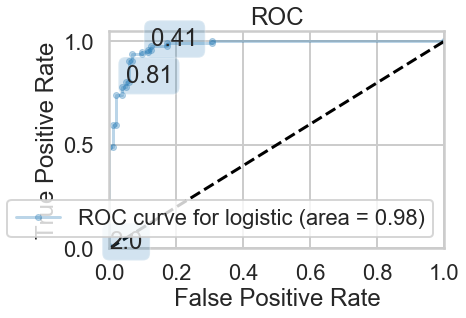

In [75]:
from sklearn.metrics import roc_curve, auc
ax=make_roc("logistic", clflog, ytest, Xtest, labe=10)

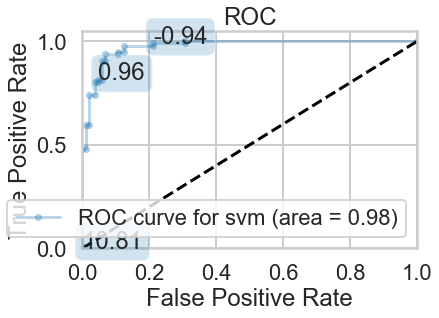

In [76]:
make_roc("svm", clfsvm, ytest, Xtest, labe=10, proba=False)

##Loss Functions


$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

###Estimation Loss
In the previous lab, we'd introduced the log loss that is used in Logistic regression and noted that it is a loss for probability estimation...and not a loss for making decisions. We'll go into these dual losses (we alluded to these in the previous lab as well) in the other notebook in this lab.

$$R_{\cal{D}}(h(x)) = -\loglike = -log \like = - log(P(y|\v{x},\v{w})).$$


Thus

\begin{eqnarray*}
R_{\cal{D}}(h(x)) &=& -log\left(\prod_{y_i \in \cal{D}} h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\
                  &=& -\sum_{y_i \in \cal{D}} log\left(h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\                  
                  &=& -\sum_{y_i \in \cal{D}} log\,h(\v{w}\cdot\v{x_i})^{y_i} + log\,\left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\\
                  &=& - \sum_{y_i \in \cal{D}} \left ( y_i log(h(\v{w}\cdot\v{x})) + ( 1 - y_i) log(1 - h(\v{w}\cdot\v{x})) \right )
\end{eqnarray*}

where

$$h(z) = \frac{1}{1 + e^{-z}}.$$

###Decision Loss

When doing cross-validation, `sklearn` will instead use the 1-0 loss or the attendant `accuracy_score` as a way of finding the best model.

From the last lab:

The 1-0 loss:

$$l = \mathbf{1}_{h \ne y}.$$

where $h$ is the classification **decision** we make (for regression we used $l = (h-y)^2$). The symbol $\mathbf{1}$ means that if $h$ is not equal to the "true" value of the point $y$, penalize by 1. Then the risk is:

$$ R_{\cal{D}}(h(x)) = \frac{1}{N} \sum_{y_i \in \cal{D}} l = \frac{1}{N} \sum_{y_i \in \cal{D}} \mathbf{1}_{h \ne y_i} $$

Thus if 5 out of 50 samples are misclassified, then the risk is 0.1. This of course means that 90% of the samples are correctly classified. This number is called the **accuracy score** or **utility**:

$$ U_{\cal{D}}(h(x))  = \frac{1}{N} \sum_{y_i \in \cal{D}} \mathbf{1}_{h = y_i} $$

###SVM

The SVM, being a classifier, uses by default the 1-0 loss in the validation part. But the estimation loss for the SVM is called the hinge loss. A bunch of losses are shown below: the red log loss, the black 1-0 loss, the green L2 loss (used in regression), and the blue hinge loss. so called, because of its shape.

![losses](./images/losses.png)

(The image is from Bishop: Pattern recognition and Machine learning)

The hinge loss comes from inspecting the structure of the minimization problem the SVM solves:

$$\cal{l}(y) = \max(0, 1 - y \cdot h) $$

where Note that $h$ should be the "raw" output of the classifier's decision function, not the predicted class label. E.g., in linear SVMs, 

$$ h = \mathbf{w} \cdot \mathbf{x}$$

(taken from https://en.wikipedia.org/wiki/Hinge_loss)

This is the solution of the optimization problem(taken from http://math.stackexchange.com/questions/327807/why-hinge-loss-is-equivalent-to-0-1-loss-in-svm):

$$\min_{\mathbf{w}} \sum_{i=1}^N [1-y_i h(x_i)]_+ +\frac{\lambda}{2}\|\mathbf{w}\|^2 $$

Setting  $\lambda=\frac{1}{C}$, this is the same minimization problem as

$$\min_{\mathbf{w}} \frac{1}{2}\|\mathbf{w}\|^2 +C \sum_{i=1}^N \xi_i$$

where

$$ \xi_i \geq 0,y_i h(x_i)\geq 1-\xi_i ~ \forall i, $$

the $\xi_i$ are the slack vectors.